The alpaca model and tokenizer code is taken as is without modification from the source.

Credits : https://www.mlexpert.io/machine-learning/tutorials/alpaca-and-llama-inference

In [1]:
!git clone https://github.com/tloen/alpaca-lora.git
%cd alpaca-lora/
!git checkout 683810b

!pip install -U pip
!pip install -r requirements.txt
!pip install torch==2.0.0

import torch
from peft import PeftModel
import transformers
import textwrap
from transformers import LlamaTokenizer, LlamaForCausalLM, GenerationConfig
from transformers.generation.utils import GreedySearchDecoderOnlyOutput
 
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DEVICE

tokenizer = LlamaTokenizer.from_pretrained("decapoda-research/llama-7b-hf")
 
model = LlamaForCausalLM.from_pretrained(
    "decapoda-research/llama-7b-hf",
    load_in_8bit=True,
    device_map="auto",
)

model = PeftModel.from_pretrained(model, "tloen/alpaca-lora-7b", torch_dtype=torch.float16)

model.config.pad_token_id = tokenizer.pad_token_id = 0  # unk
model.config.bos_token_id = 1
model.config.eos_token_id = 2
 
model = model.eval()
model = torch.compile(model)

PROMPT_TEMPLATE = f"""
Below is an instruction that describes a task. Write a response that appropriately completes the request.
 
### Instruction:
[INSTRUCTION]
 
### Response:
"""

def format_response(response: GreedySearchDecoderOnlyOutput) -> str:
    decoded_output = tokenizer.decode(response.sequences[0])
    response = decoded_output.split("### Response:")[1].strip()
    return "\n".join(textwrap.wrap(response))

def ask_alpaca(prompt: str, model: PeftModel = model) -> str:
    prompt = create_prompt(prompt)
    response = generate_response(prompt, model)
    # print(format_response(response))
    return format_response(response)

def generate_response(prompt: str, model: PeftModel) -> GreedySearchDecoderOnlyOutput:
    encoding = tokenizer(prompt, return_tensors="pt")
    input_ids = encoding["input_ids"].to(DEVICE)
 
    generation_config = GenerationConfig(
        temperature=0.1,
        top_p=0.75,
        repetition_penalty=1.1,
    )
    with torch.inference_mode():
        return model.generate(
            input_ids=input_ids,
            generation_config=generation_config,
            return_dict_in_generate=True,
            output_scores=True,
            max_new_tokens=256,
        )

def create_prompt(instruction: str) -> str:
    return PROMPT_TEMPLATE.replace("[INSTRUCTION]", instruction)
 
print(create_prompt("What is the meaning of life?"))

Cloning into 'alpaca-lora'...
remote: Enumerating objects: 607, done.
remote: Counting objects: 100% (51/51), done.
remote: Compressing objects: 100% (32/32), done.
remote: Total 607 (delta 28), reused 34 (delta 19), pack-reused 556
Receiving objects: 100% (607/607), 27.78 MiB | 5.12 MiB/s, done.
Resolving deltas: 100% (360/360), done.
Updating files: 100% (27/27), done.
/content/alpaca-lora
Note: switching to '683810b'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by switching back to a branch.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -c with the switch command. Example:

  git switch -c <new-branch-name>

Or undo this operation with:

  git switch -

Turn off this advice by setting config variable advice.detachedHead to false

HEAD is now at 683810b Print warning on checkpoint not fou

/usr/local/lib/python3.9/dist-packages/bitsandbytes/cuda_setup/main.py:145: UserWarning: /usr/lib64-nvidia did not contain ['libcudart.so', 'libcudart.so.11.0', 'libcudart.so.12.0'] as expected! Searching further paths...
  warn(msg)
/usr/local/lib/python3.9/dist-packages/bitsandbytes/cuda_setup/main.py:145: UserWarning: WARNING: The following directories listed in your path were found to be non-existent: {PosixPath('/sys/fs/cgroup/memory.events /var/colab/cgroup/jupyter-children/memory.events')}
  warn(msg)
/usr/local/lib/python3.9/dist-packages/bitsandbytes/cuda_setup/main.py:145: UserWarning: WARNING: The following directories listed in your path were found to be non-existent: {PosixPath('http'), PosixPath('//172.28.0.1'), PosixPath('8013')}
  warn(msg)
/usr/local/lib/python3.9/dist-packages/bitsandbytes/cuda_setup/main.py:145: UserWarning: WARNING: The following directories listed in your path were found to be non-existent: {PosixPath('--listen_host=172.28.0.12 --target_host=172.28

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'LLaMATokenizer'. 
The class this function is called from is 'LlamaTokenizer'.
Overriding torch_dtype=None with `torch_dtype=torch.float16` due to requirements of `bitsandbytes` to enable model loading in mixed int8. Either pass torch_dtype=torch.float16 or don't pass this argument at all to remove this warning.


Loading checkpoint shards:   0%|          | 0/33 [00:00<?, ?it/s]


Below is an instruction that describes a task. Write a response that appropriately completes the request.
 
### Instruction:
What is the meaning of life?
 
### Response:



In [2]:
ask_alpaca("2+2=")

4


In [38]:
import torch as t
from transformers import GPT2LMHeadModel, GPT2Tokenizer # pip install transformers
from transformers import AutoModelForCausalLM, AutoTokenizer, AutoConfig
import matplotlib.pyplot as plt
import time
import numpy as np
import sklearn
import pickle
import re # regular expressions, useful for decoding the output
import pandas as pd

In [39]:
def create_dataset(i_start=0, i_end=50, operation=t.add):

    """(1 pt) Create a dataset of pairs of numbers to calculate an operation
    on.
    DO NOT USE A FOR LOOP. 
    Use pytorch functions, possibilities include
    meshgrid, stack, reshape, repeat, tile.
    (Note you'll have to use for loops on string stuff in other functions)
    The dataset should be a tuple of two tensors, X and y, where X is a Nx2
    tensor of numbers to add,
    and y is a N tensor of the correct answers.
    E.g., if i_start=0, i_end=2, then X should be
    tensor([[0,0,1,1],[0,1,0,1]]).T and y should be tensor([0,1,1,2]).

    I recommend doing all pairs of sums involving 0-49, but you may modify
    this.
    """
    # TODO 

    # Create tensors for the x and y values
    x1 = t.arange(i_start, i_end)
    x2 = t.arange(i_start, i_end)

    # # Using MeshGrid
    # x1, x2 = t.meshgrid(x1, x2)
    # x1 = x1.reshape(-1)
    # x2 = x2.reshape(-1)
    # X = t.stack((x1, x2), dim=1)

    # Using Tile
    x1 = x1.tile(((i_end - i_start),1))
    x1 = x1.T.reshape(-1,)
    x2 = x2.tile(((i_end - i_start)))
    X = t.stack((x1, x2), dim=0)

    # Perform the desired operation (addition in this case)
    
    if operation == t.add:
        y = x1 + x2


    return X, y

In [40]:
def encode_problems(X, strategy='baseline'):
    """(1 pts) Encode the problems as strings. For example, if X is
    [[0,0,1,1],[0,1,0,1]],
    then the baseline output should be ["0+0=", "0+1=", "1+0=", "1+1="]""" 
    
    # Encode the problem based on various prompts.
    # In case nothing is provided, use baseline

    output_strings = []
    
    for xi in X.T:
        if strategy == 'word_problem':
            encode_string ="Add {} and {}".format(xi[0], xi[1])
        elif strategy == 'code':
            encode_string ="A={}, B={}, A+B=".format(xi[0], xi[1])
        elif strategy == 'algebra':
            encode_string ="if x={} and y={} and z=x+y, then what is z?".format(xi[0], xi[1])
        elif strategy == 'in_context':
            encode_string ="if 7+11=18 and 4+12=16 then {}+{}=".format(xi[0], xi[1])
        else:
            encode_string = "{}+{}=".format(xi[0],xi[1])
        
        output_strings.append(encode_string) 
    
    return output_strings

In [41]:
def generate_text(model, tokenizer, prompts, verbose=True, device='cpu'): 
    """(3 pts) Complete the prompt using the LLM.
    1. Tokenize the prompts:
    https://huggingface.co/docs/transformers/preprocessing
        Put data and model on device to speed up computations
        (Note that in real life, you'd use a dataloader to do this efficiently
    in the background during training.)
    2. Generate text using the model.
        Turn off gradient tracking to save memory.
        Determine the sampling hyper-parameters.
        You may need to do it in batches, depending on memory constraints
    3. Use the tokenizer to decode the output.
    You will need to optionally print out the tokenization of the input and
    output strings for use in the write-up.
    """

    t0 = time.time()

    # TODO: tokenize
    encoded_input = tokenizer(prompts, return_tensors="pt").input_ids.to(device)

    print ()
    # # TODO: generate text, turn off gradient tracking 
    output = []
    batch = 2
    with t.no_grad():
        for i in range(0,encoded_input.shape[0],batch):
            if i + batch <= encoded_input.shape[0]:
                output.extend(model.generate(encoded_input[i:i+batch]))
            else:
                output.extend(model.generate(encoded_input[i:encoded_input.shape[0]]))
    
    # # TODO: decode output, output_strings = ...
    output_strings = []

    for out in output:
        output_strings.append(tokenizer.decode(out))
    
    if verbose:

        # TODO: print example tokenization for write-up
        print ('____________')
        print ('input')
        print (prompts[0])
        print ('____________')
        print ('____________')
        print ('output')
        print (output_strings[0])
        print ('____________')
        print("Time to generate text: ", time.time() - t0) # It took 4 minutes to do 25000 prompts on an NVIDIA 1080Ti.

    return output_strings

In [42]:
def decode_output(output_strings, strategy='baseline', verbose=True):
    """(1 pt) Decode the output strings into a list of integers. Use "t.nan"
    for failed responses.
    One suggestion is to split on non-numeric characters, then convert to int.
    And use try/except to catch errors.
    """

    # Use regex to get the first numerical value.
    # In case no numerical value, store nan
    # We only look at first value as we have removed the input string from this output
    import re

    # TODO: 
    y_hat = []
    for s in output_strings:
        y = re.findall(r'-?\d+(?:\.\d+)?', s)
        y_hat.append(float(y[-1]) if len(y)>0 else t.nan)

    return y_hat

In [49]:
def linear_classifier(X,y, strategy):

    import numpy as np
    import matplotlib.pyplot as plt
    from sklearn.neural_network import MLPClassifier
    from sklearn.metrics import confusion_matrix, classification_report

    clf = MLPClassifier(hidden_layer_sizes=(64,64,64,64,32,16,8,), activation='relu', solver='lbfgs', max_iter = 1000, )
    clf.fit(X, y)

    y_pred = clf.predict(X)
    acc = np.sum(y_pred == y)/y_pred.shape[0]

    cm = confusion_matrix(y, y_pred)
    fnr = cm[1, 0] / (cm[1, 0] + cm[1, 1])

    print(f"False negative rate: {fnr}")
    print ('acc of classifier is {}'.format(acc))

    def plot_decision_regions(clf, X, y, resolution=0.1):
        x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
        y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, resolution),
                            np.arange(y_min, y_max, resolution))
        Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        plt.contourf(xx, yy, Z, alpha=0.3)

    plt.title('{}, addition, MLP Classifier'.format(strategy))
    plt.xlabel('x1')
    plt.ylabel('x2')
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    plt.xticks(np.arange(x_min, x_max, step=2))
    plt.yticks(np.arange(x_min, x_max, step=2))
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired)
    plot_decision_regions(clf, X, y)
    plt.legend()
    plt.show()

    return acc, fnr

In [47]:
def analyze_results(X, y, y_hats, strategies):
    """(3 pts) Analyze the results.
    Output the accuracy of each strategy.
    Plot a scatter plot of the problems “x1+x2” with x1,x2 on each axis,
    and different plot markers to indicate whether the answer from your LLM was
    correct.
    (See write-up instructions for requirements on plots)
    Train a classifier to predict whether the LLM gave the correct response
    (using scikit-learn, for example)
    and plot the classifier boundary over the scatter plot with “contour”. (Use
    whatever classifier looks appropriate)"""


    results_list = []


    for strategy, y_hat in zip(strategies, y_hats):

        print ()
        print (' ____________ ')
        print (strategy)
        # accuracy of strategies
        accuracy = t.sum(t.tensor(y_hat) == y)/ len(y_hat)
        print ('accuracy of {} is {}'.format(strategy, accuracy))

        # scatter plot
        correct = []
        incorrect = []
        for x1, x2, true,pred in zip(X[0], X[1], y,y_hat):
            if true == pred:
                correct.append([x1,x2])
            else:
                incorrect.append([x1,x2]) 

        correct = t.tensor(correct)
        incorrect = t.tensor(incorrect)

        plt.title('{}, Multiplication'.format(strategy))
        plt.xlabel('x1')
        plt.ylabel('x2')
        plt.xticks(np.arange(min(X[0])-2, max(X[0])+2, step=2))
        plt.yticks(np.arange(min(X[1])-2, max(X[1])+2, step=2))
        if len(correct):
            plt.scatter(correct[:,0], correct[:,1], c='green', s=25, label='correct')
        if len(incorrect):
            plt.scatter(incorrect[:,0], incorrect[:,1], c='red', s=25, label='incorrect')
        plt.legend()
        plt.show()

        # classifier
        # create a dataset for classifier

        x_train = X.T
        y_train = [1 if i else 0 for i in y == t.tensor(y_hat)]
        if len(correct):
            acc, fnr = linear_classifier(x_train, y_train, strategy)
            results_list.append({'strategy':strategy, 'miss_rate (in %)':fnr*100, 'accuracy (in %)':accuracy.item()*100, 'classifier_accuracy (in %)':acc*100})
        else:
            results_list.append({'strategy':strategy, 'miss_rate (in %)':'N/A', 'accuracy (in %)':accuracy.item()*100, 'classifier_accuracy (in %)':0})

    df = pd.DataFrame.from_records(results_list)
    print ('The resultant Accuracies')
    print ()
    print ()
    print (df)


 ____________ 
word_problem
accuracy of word_problem is 0.8956249952316284


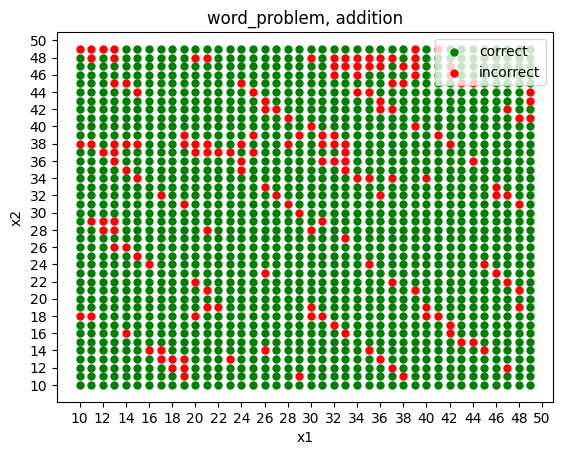

/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


acc of classifier is 0.89625


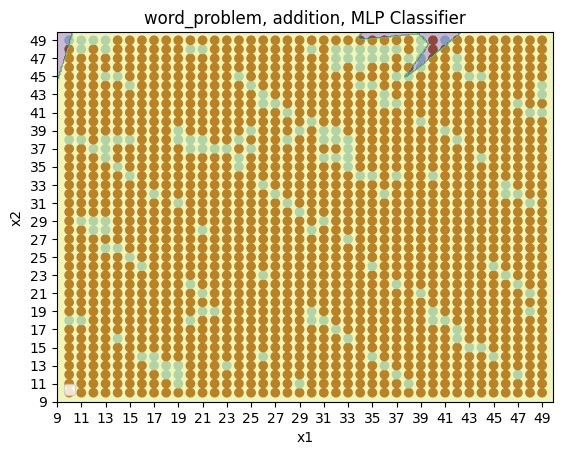


 ____________ 
code
accuracy of code is 0.4181250035762787


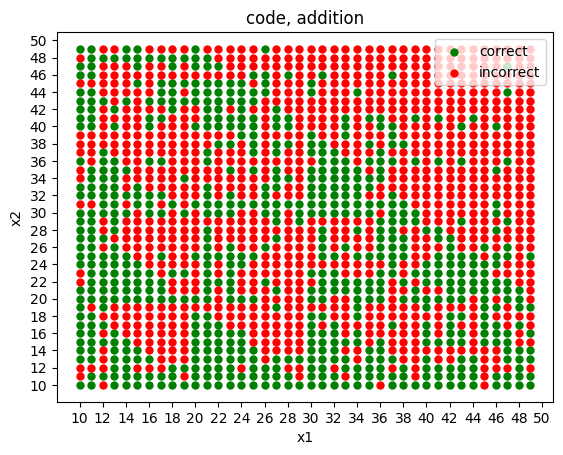

/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


acc of classifier is 0.71


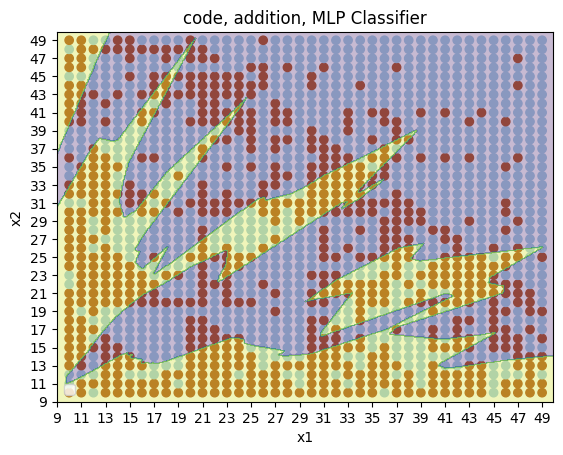


 ____________ 
algebra
accuracy of algebra is 0.918749988079071


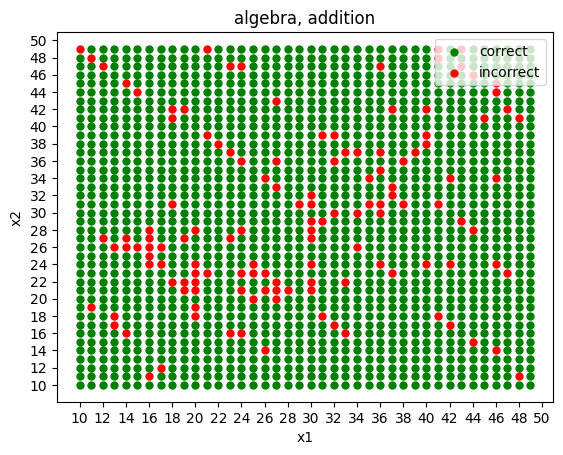

/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


acc of classifier is 0.91875


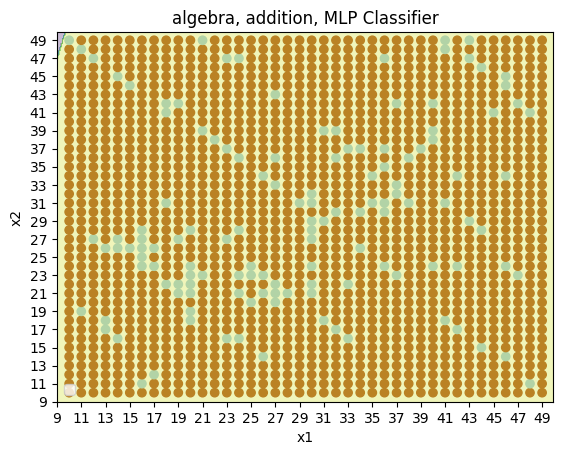


 ____________ 
in_context
accuracy of in_context is 0.40312498807907104


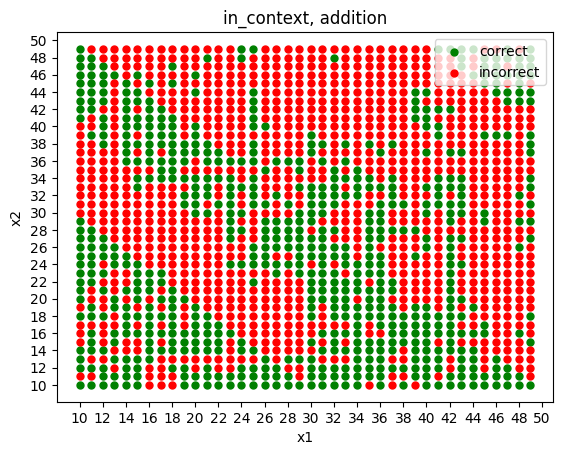

/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


acc of classifier is 0.68625


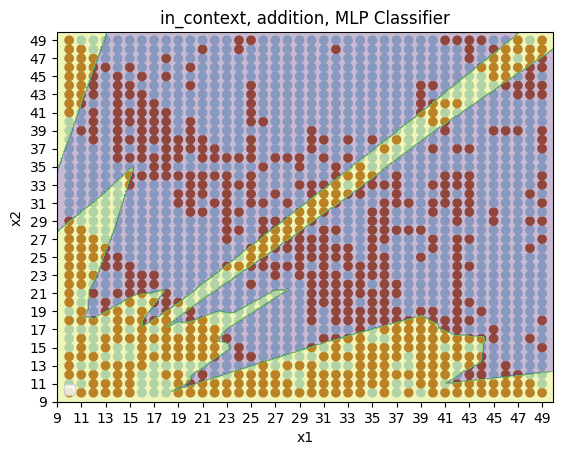


 ____________ 
baseline
accuracy of baseline is 0.5431249737739563


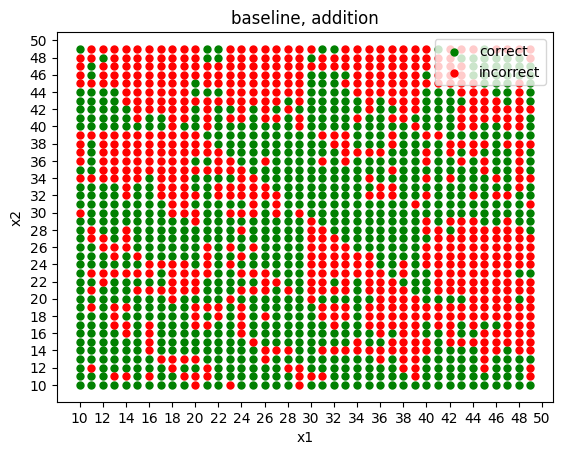

/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


acc of classifier is 0.71


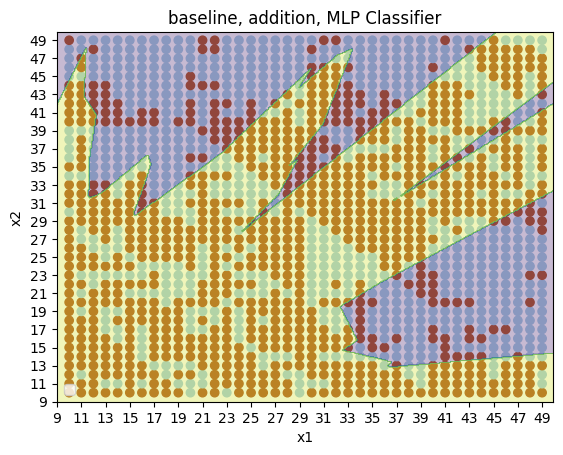

The resultant Accuracies


       strategy  accuracy (in %)  classifier_accuracy (in %)
0  word_problem        89.562500                      89.625
1          code        41.812500                      71.000
2       algebra        91.874999                      91.875
3    in_context        40.312499                      68.625
4      baseline        54.312497                      71.000


In [34]:
if __name__ == "__main__":
    device = t.device("cuda" if t.cuda.is_available() else "cpu") # Use GPU if available

    # Create Dataset of X and Y
    X, y = create_dataset(10, 50)

    # As the model and tokenizer work a little differently on Alpaca, so we will directly be running inference on the model. Otherwise we would need to do the input formatting ourselves. 
    

    # list of lists of predicted answers, y_hat, for each strategy 
    y_hats = [] 
    
    # Various strategies to be used
    strategies = ['word_problem', 'code', 'algebra', 'in_context', 'baseline']

    for strategy in strategies:

        # encode string based on strategy
        input_strings = encode_problems(X, strategy=strategy)
        # print ()
        # print ('-----------')
        # print ('input_strings')
        # print (input_strings)

        output_strings = []
        # generate output by passing it through the model
        for input_str in input_strings:
          output_strings.append(ask_alpaca(input_str))
        
        # print ('output_strings')
        # print (output_strings)

        # decode the output to get first numerical number or nan
        y_hat = decode_output(output_strings, strategy=strategy)
        # print ('y_hat')
        # print (y_hat)

        # append to lists
        y_hats.append(y_hat) 
    
    # analyze the output
    analyze_results(X, y, y_hats, strategies)


 ____________ 
word_problem
accuracy of word_problem is 0.8956249952316284


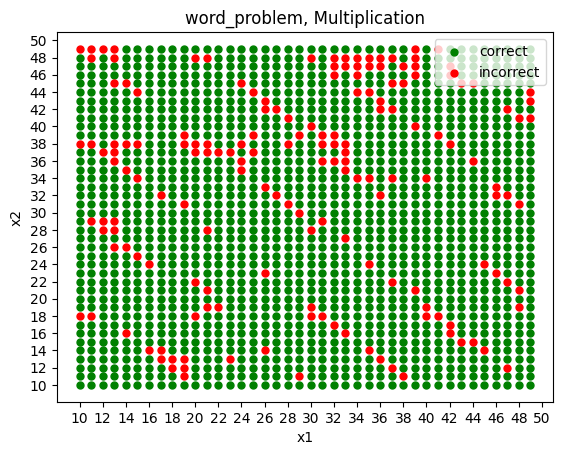

/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


False negative rate: 0.0
acc of classifier is 0.89625


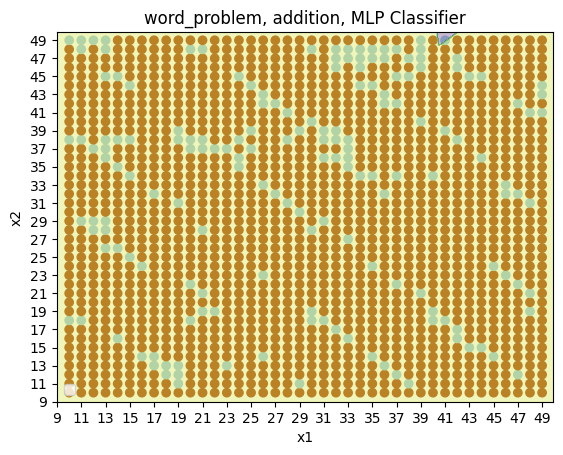


 ____________ 
code
accuracy of code is 0.4181250035762787


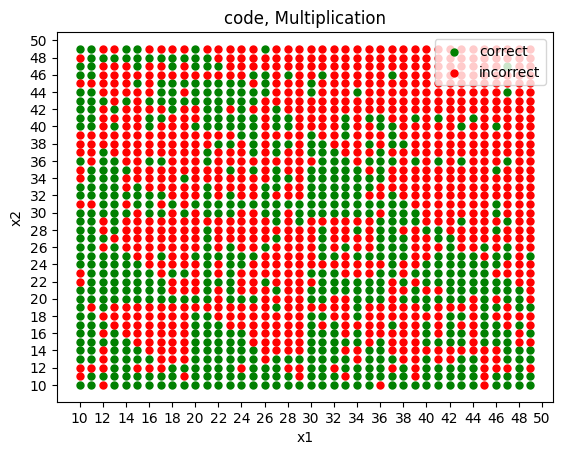

/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


False negative rate: 0.40956651718983555
acc of classifier is 0.72


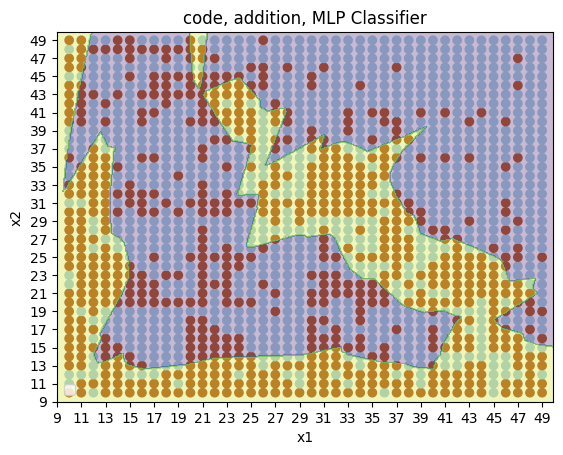


 ____________ 
algebra
accuracy of algebra is 0.918749988079071


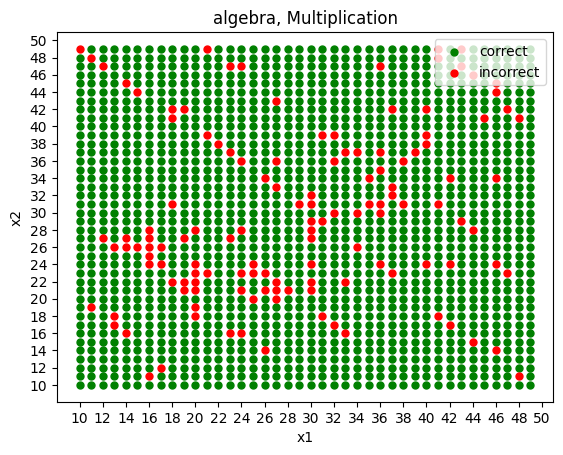

/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


False negative rate: 0.0
acc of classifier is 0.919375


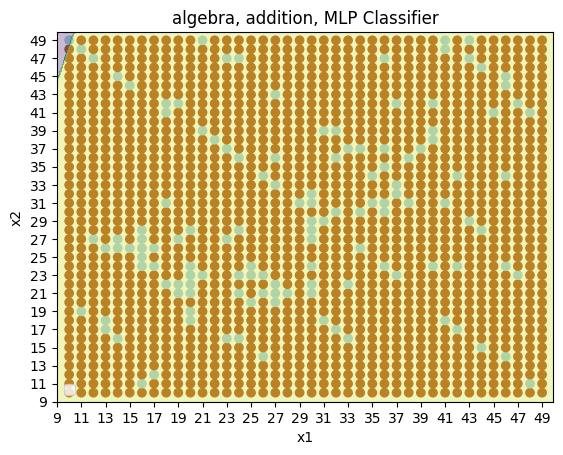


 ____________ 
in_context
accuracy of in_context is 0.40312498807907104


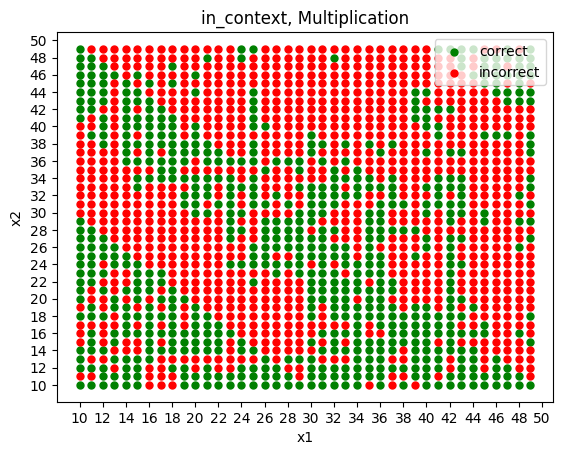

False negative rate: 1.0
acc of classifier is 0.596875


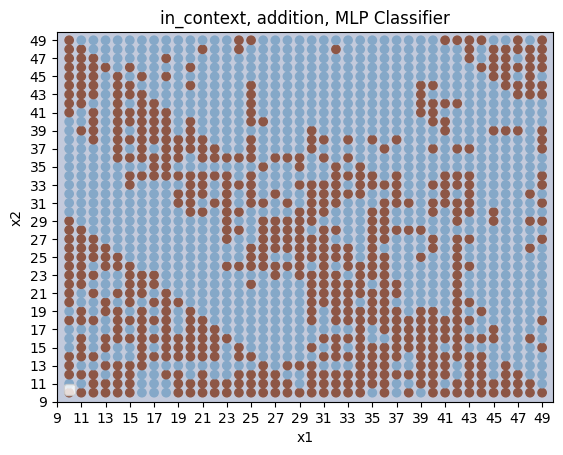


 ____________ 
baseline
accuracy of baseline is 0.5431249737739563


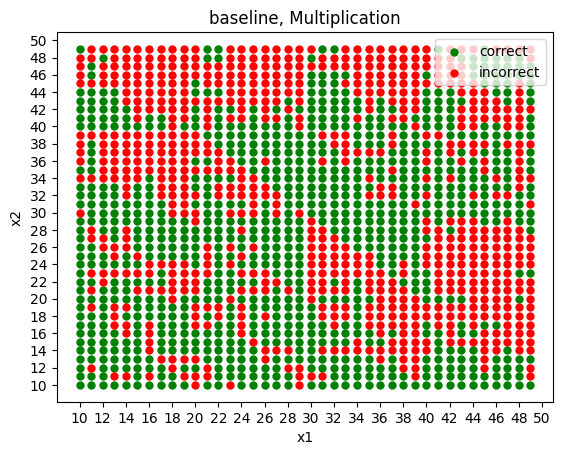

/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


False negative rate: 0.17261219792865362
acc of classifier is 0.71375


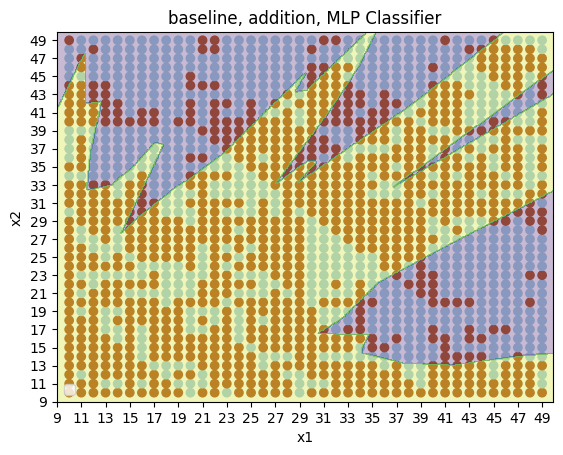

The resultant Accuracies


       strategy  miss_rate (in %)  accuracy (in %)  classifier_accuracy (in %)
0  word_problem          0.000000        89.562500                     89.6250
1          code         40.956652        41.812500                     72.0000
2       algebra          0.000000        91.874999                     91.9375
3    in_context        100.000000        40.312499                     59.6875
4      baseline         17.261220        54.312497                     71.3750


In [50]:
analyze_results(X, y, y_hats, strategies)

In [51]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

In [37]:
!sudo apt-get update
!sudo apt-get install texlive-xetex texlive-fonts-recommended

Get:1 https://cloud.r-project.org/bin/linux/ubuntu focal-cran40/ InRelease [3,622 B]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  InRelease [1,581 B]
Get:3 https://cloud.r-project.org/bin/linux/ubuntu focal-cran40/ Packages [76.4 kB]
Get:4 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]
Get:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  Packages [995 kB]
Get:6 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu focal InRelease [18.1 kB]
Hit:7 http://archive.ubuntu.com/ubuntu focal InRelease
Get:8 http://archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]
Hit:9 http://ppa.launchpad.net/cran/libgit2/ubuntu focal InRelease
Get:10 http://security.ubuntu.com/ubuntu focal-security/universe amd64 Packages [1,034 kB]
Hit:11 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu focal InRelease
Get:12 http://archive.ubuntu.com/ubuntu focal-backports InRelease [108 kB]
Hit:13 http://ppa.launchpad.net/graphics

In [ ]:
!jupyter nbconvert --log-level CRITICAL --to pdf ./alpaca_lora.ipynb